In [186]:
import numpy as np
import pandas as pd
import math
import keras
import csv
import io
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import files
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [187]:
#uploaded = files.upload()

In [188]:
data = pd.read_csv(io.BytesIO(uploaded['Bitstamp_BTCUSD_d.csv']), parse_dates=['date'])
data = data.dropna()
data = data.drop(columns=['symbol', 'unix', 'Volume BTC', 'Volume USD'])
data_sort = data.sort_values('date') #sortiramo radi prikaza close vrednosti na grafu
data_sort.head()

,date,open,high,low,close
2731,2014-11-28,363.59,381.34,360.57,376.28
2730,2014-11-29,376.42,386.60,372.25,376.72
2729,2014-11-30,376.57,381.99,373.32,373.34
2728,2014-12-01,376.40,382.31,373.03,378.39
2727,2014-12-02,378.39,382.86,375.23,379.25


Text(0, 0.5, 'Close Price (USD)')

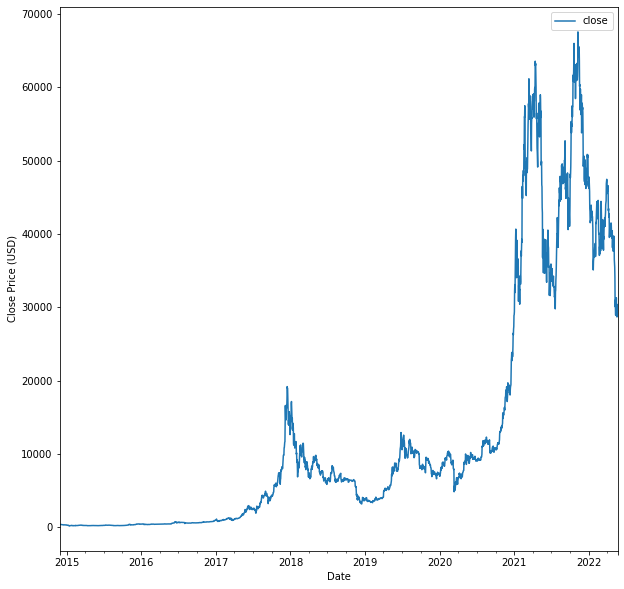

In [189]:
close_plot = data_sort.plot(x='date', y='close');
close_plot.set_xlabel("Date")
close_plot.set_ylabel("Close Price (USD)")

In [190]:
data = data[['close']]
dataset = data.values
dataset = dataset.astype('float32').reshape(-1, 1)
dataset

array([[29248.11],
       [29176.7 ],
       [30290.33],
       ...,
       [  373.34],
       [  376.72],
       [  376.28]], dtype=float32)

In [191]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [192]:
dataset

array([[0.43156385],
       [0.4305043 ],
       [0.44702774],
       ...,
       [0.00313575],
       [0.0031859 ],
       [0.00317937]], dtype=float32)

In [193]:
dataset.shape

(2732, 1)

In [194]:
train_test_split = 0.8

num_train = int(train_test_split * dataset.shape[0]) #broj za trening je % za train split * broj redova
train = dataset[:num_train, :]
test = dataset[num_train:, :]
print(len(train), len(test))

2185 547


In [195]:
def preprocess(data_raw, seq_len):
  dataX, dataY = [], []
  for i in range(len(data_raw)-seq_len-1):
    
    dataX.append(data_raw[i: i+seq_len])
    dataY.append(data_raw[i:(i+seq_len), 0])

  return np.array(dataX), np.array(dataY)

In [196]:
X_train, y_train = preprocess(dataset, 10)
X_test, y_test = preprocess(dataset, 10)

In [197]:
y_train.shape

(2721, 10)

In [198]:
# samples, seq_len, features
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [199]:
X_train.shape[-1]

10

In [200]:
# WINDOW_SIZE = 99

# model = keras.Sequential()

# model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
#                         input_shape=(WINDOW_SIZE, X_train.shape[-1])))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
# # treba 4
# model.add(Dense(1))

# model.add(Activation('linear'))

WINDOW_SIZE = 4

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE,
                        input_shape=(1, X_train.shape[-1]))))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

In [201]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [202]:
BATCH_SIZE = 256

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1,
    verbose=2
)
# verbose 1 daje ogroman loss

Epoch 1/100
10/10 - 4s - loss: 0.0909 - val_loss: 2.9614e-04 - 4s/epoch - 419ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0662 - val_loss: 0.0012 - 63ms/epoch - 6ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0455 - val_loss: 0.0024 - 59ms/epoch - 6ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0348 - val_loss: 0.0036 - 63ms/epoch - 6ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0244 - val_loss: 0.0043 - 61ms/epoch - 6ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0194 - val_loss: 0.0046 - 67ms/epoch - 7ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0159 - val_loss: 0.0044 - 61ms/epoch - 6ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0127 - val_loss: 0.0038 - 62ms/epoch - 6ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0121 - val_loss: 0.0030 - 59ms/epoch - 6ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0099 - val_loss: 0.0023 - 59ms/epoch - 6ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0092 - val_loss: 0.0016 - 68ms/epoch - 7ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0085 - val_loss: 0.0011 - 65ms/epoch - 7ms/step
Epoch 13/100
10/10 - 

In [203]:
model.evaluate(X_test, y_test)

86/86 [==============================] - 0s 2ms/step - loss: 4.9590e-04


0.0004959027864970267

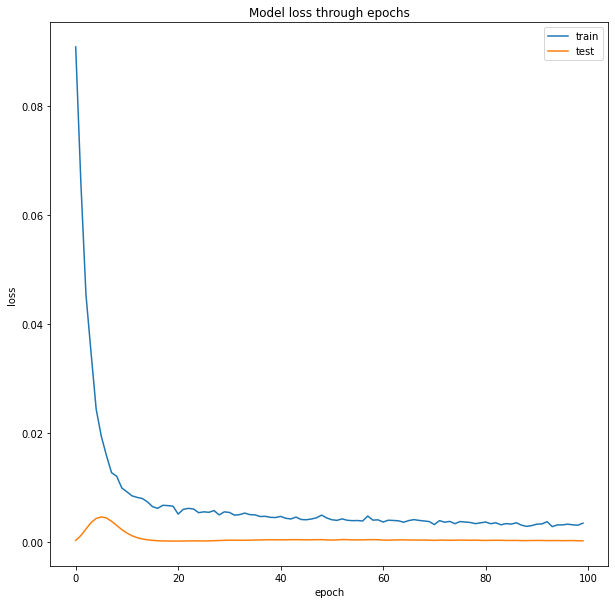

In [204]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss through epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [205]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train)

test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test)

In [206]:
trainPredPlot = np.empty_like(dataset)
trainPredPlot[:, :] = np.nan
trainPredPlot[1:len(train_pred)+1, :] = train_pred

testPredPlot = np.empty_like(dataset)
testPredPlot[:, :] = np.nan
testPredPlot[1:len(test_pred)+1, :] = test_pred

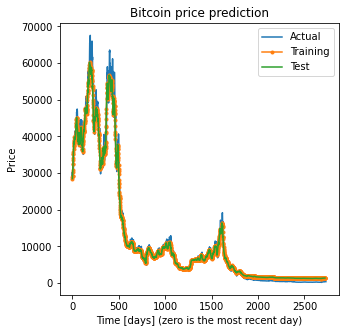

In [207]:
plt.plot(data['close'], label='Actual')
plt.plot(pd.DataFrame(trainPredPlot, columns=['close'], index=data.index).close, label='Training', marker='.')
plt.plot(pd.DataFrame(testPredPlot, columns=['close'], index=data.index).close, label='Test')
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Time [days] (zero is the most recent day)')
plt.ylabel('Price')
plt.title('Bitcoin price prediction')
plt.show()